In [1]:
spark

In [19]:
sc = spark.sparkContext

In [25]:
num_executors = int(sc._conf.get('spark.executor.instances'))
executor_cores = int(sc._conf.get('spark.executor.cores'))

In [2]:
from __future__ import print_function

In [27]:
print('- Number of executors:', num_executors)
print('- Executor cores:', executor_cores)

- Number of executors: 22
- Executor cores: 4


## Load train and test dataframes

In [3]:
%%time
trainDF = spark.read.format('parquet') \
        .load('/project/ML/data/trainUndersampled_v2_rep.parquet') \
        .select(['HLF_input', 'label'])
        
testDF = spark.read.format('parquet') \
        .load('/project/ML/data/testUndersampled_v2_rep.parquet') \
        .select(['HLF_input', 'label', 'encoded_label'])    
        
test_events = testDF.count()
train_events = trainDF.count()
print('There are', train_events, 'training events')
print('There are', test_events, 'test events')

There are 3423028 training events
There are 856078 test events
CPU times: user 6.19 ms, sys: 5.86 ms, total: 12 ms
Wall time: 15.4 s


In [5]:
trainDF.printSchema()

root
 |-- HLF_input: vector (nullable = true)
 |-- label: long (nullable = true)



## Start BigDL

In [28]:
from bigdl.nn.layer import *
from bigdl.optim.optimizer import *
from bigdl.nn.criterion import *
from bigdl.util.common import *
from bigdl.nn.initialization_method import *

import numpy as np 

init_engine()

In [29]:
model = Sequential()
model.add(Linear(14,50))
model.add(ReLU())
model.add(Linear(50,20))
model.add(ReLU())
model.add(Linear(20,10))
model.add(ReLU())
model.add(Linear(10,3))
model.add(SoftMax())

creating: createSequential
creating: createLinear
creating: createReLU
creating: createLinear
creating: createReLU
creating: createLinear
creating: createReLU
creating: createLinear
creating: createSoftMax


In [30]:
trainRDD = trainDF.rdd.map(lambda row: Sample.from_ndarray(np.array(row.HLF_input).flatten(),
                                                         np.array(row.label)+1))
testRDD = testDF.rdd.map(lambda row: Sample.from_ndarray(np.array(row.HLF_input).flatten(),
                                                         np.array(row.label)+1))

In [31]:
trainRDD.take(1)

[Sample: features: [JTensor: storage: [7.2775073e-03 3.1238062e-02 3.3906862e-01 1.6429867e-03 6.6666670e-02
  0.0000000e+00 9.8582804e-03 4.3469006e-01 8.3038348e-01 4.9343788e-16
  1.0171582e-01 0.0000000e+00 0.0000000e+00 1.0000000e+00], shape: [14], float], labels: [JTensor: storage: [3.], shape: [1], float]]

In [36]:
import datetime as dt
num_epochs =  50
batch_size = 200

BDL_batch_size = batch_size*num_executors*executor_cores 

optimizer = Optimizer(model=model, 
                      training_rdd=trainRDD, 
                      criterion=CrossEntropyCriterion(),
                      optim_method=Adam(),
                      end_trigger=MaxEpoch(num_epochs),
                      batch_size=BDL_batch_size)

app_name = 'test-bdl-'+dt.datetime.now().strftime("%Y%m%d-%H%M%S")
train_summary = TrainSummary(log_dir='/tmp/bigdl_summaries', app_name=app_name)
optimizer.set_train_summary(train_summary)

creating: createCrossEntropyCriterion
creating: createAdam
creating: createMaxEpoch
creating: createDistriOptimizer
creating: createTrainSummary


In [37]:
%time trained_model = optimizer.optimize()

CPU times: user 113 ms, sys: 121 ms, total: 234 ms
Wall time: 13min 34s


In [38]:
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>


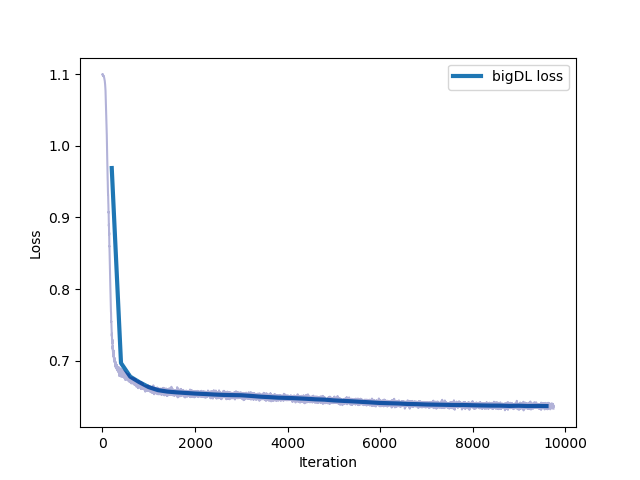

In [39]:
%matplotlib notebook
loss = np.array(train_summary.read_scalar("Loss"))

iteration = []
avg_loss = []
batch_loss = 0

for it, l in enumerate(loss[:,1]):
    batch_loss += l
    if (it%batch_size==0) and (it>0):
        avg_loss.append(batch_loss/batch_size)
        iteration.append(it)
        batch_loss = 0

plt.figure()
plt.plot(iteration, avg_loss, lw=3, label='bigDL loss')
plt.plot(loss[:,0], loss[:,1], alpha=0.3, color='navy')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [40]:
pred = trained_model.predict(testRDD)

In [41]:
%%time
y_pred = np.asarray(pred.collect())
y_true = np.asarray(testDF.select('encoded_label').rdd\
                    .map(lambda row: np.asarray(row.encoded_label)).collect())

CPU times: user 3.03 s, sys: 249 ms, total: 3.28 s
Wall time: 10 s


In [42]:
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [43]:
roc_auc

{0: 0.9836738148485296, 1: 0.9780418246200329, 2: 0.9724074919277768}

<IPython.core.display.Javascript object>


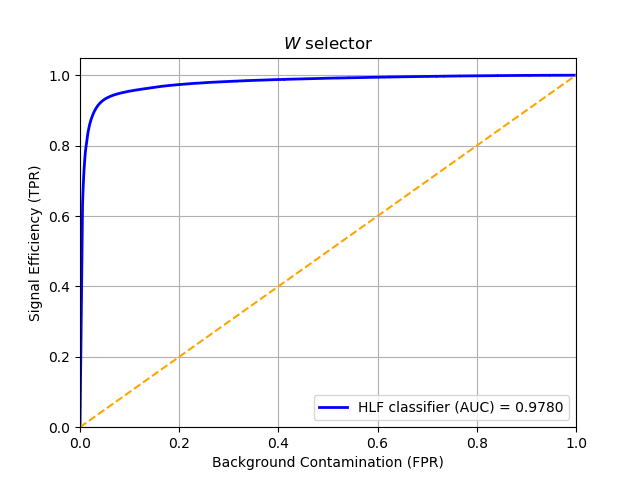

In [44]:
plt.figure()
plt.plot(fpr[1], tpr[1], color='blue',
         lw=2, label='HLF classifier (AUC) = %0.4f' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='orange', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Background Contamination (FPR)')
plt.ylabel('Signal Efficiency (TPR)')
plt.title('$W$ selector')
plt.legend(loc="lower right")
plt.grid()
plt.show()